In [25]:
%matplotlib notebook

from math import sin, cos, radians, pi
import numpy as np
import matplotlib.pyplot as plt

# NOTE: All units should be in SI units (meters, kilograms, etc.)

# Initial conditions
INITIAL_ANGLE = radians(45.0)
INITIAL_VELOCITY = 50
INITIAL_HEIGHT = 0.5

# Characteristics of the ball
BALL_DIAMETER = 0.1778 # 7 inches
BALL_MASS = 0.142 # 5 ounces
BALL_DRAG_COEFFICIENT = 0.47
BALL_SPIN = -0.1 # Angular velocity in revolutions per second

# Characteristics of the world
AIR_DENSITY = 1.225
GRAVITY = 9.80665

# Simulation settings
SIM_DT = 0.01
SIM_MAX_TIME = 10.0

In [26]:
def setup_initial_values(initial_angle, initial_velocity):
    global velocity
    velocity = np.array([
        initial_velocity * cos(initial_angle),
        initial_velocity * sin(initial_angle)
    ])
    global position
    position = np.array([
        0,
        INITIAL_HEIGHT
    ])

def calc_acceleration(use_drag=False, use_magnus=False):
    # Calculate acceleration due to gravity
    result = np.array([
        0,
        -GRAVITY
    ])
    
    if use_drag:
        # Aerodynamic drag calculation from Wikipedia: https://en.wikipedia.org/wiki/Drag_equation
        force = 0.5 * BALL_DRAG_COEFFICIENT * AIR_DENSITY * (pi * (BALL_DIAMETER / 2) ** 2) * -velocity ** 2
        result += force / BALL_MASS
    if use_magnus:
        # Magnus effect calculation from NASA: https://www.grc.nasa.gov/WWW/K-12/airplane/beach.html
        force = 4.0 / 3.0 * (4.0 * pi ** 2 * BALL_DIAMETER ** 3 * BALL_SPIN * AIR_DENSITY * -velocity)
        result += force / BALL_MASS
    
    return result

def run_simulation(initial_angle=INITIAL_ANGLE, initial_velocity=INITIAL_VELOCITY, use_drag=False, use_magnus=False):
    global position
    global velocity
    setup_initial_values(initial_angle, initial_velocity)
    
    position_arr = [position]
    velocity_arr = [velocity]

    time = 0
    while position[1] > 0 and time < SIM_MAX_TIME:
        # Calculate acceleration
        acceleration = calc_acceleration(use_drag, use_magnus)
        # Use calculated acceleration to change velocity
        velocity = velocity + acceleration * SIM_DT
        # Use calculated velocity to change position
        position = position + velocity * SIM_DT

        # Record position
        position_arr.append(position)
        velocity_arr.append(velocity)

        # Increment time by dt
        time += SIM_DT
    return (position_arr, velocity_arr)

<IPython.core.display.Javascript object>


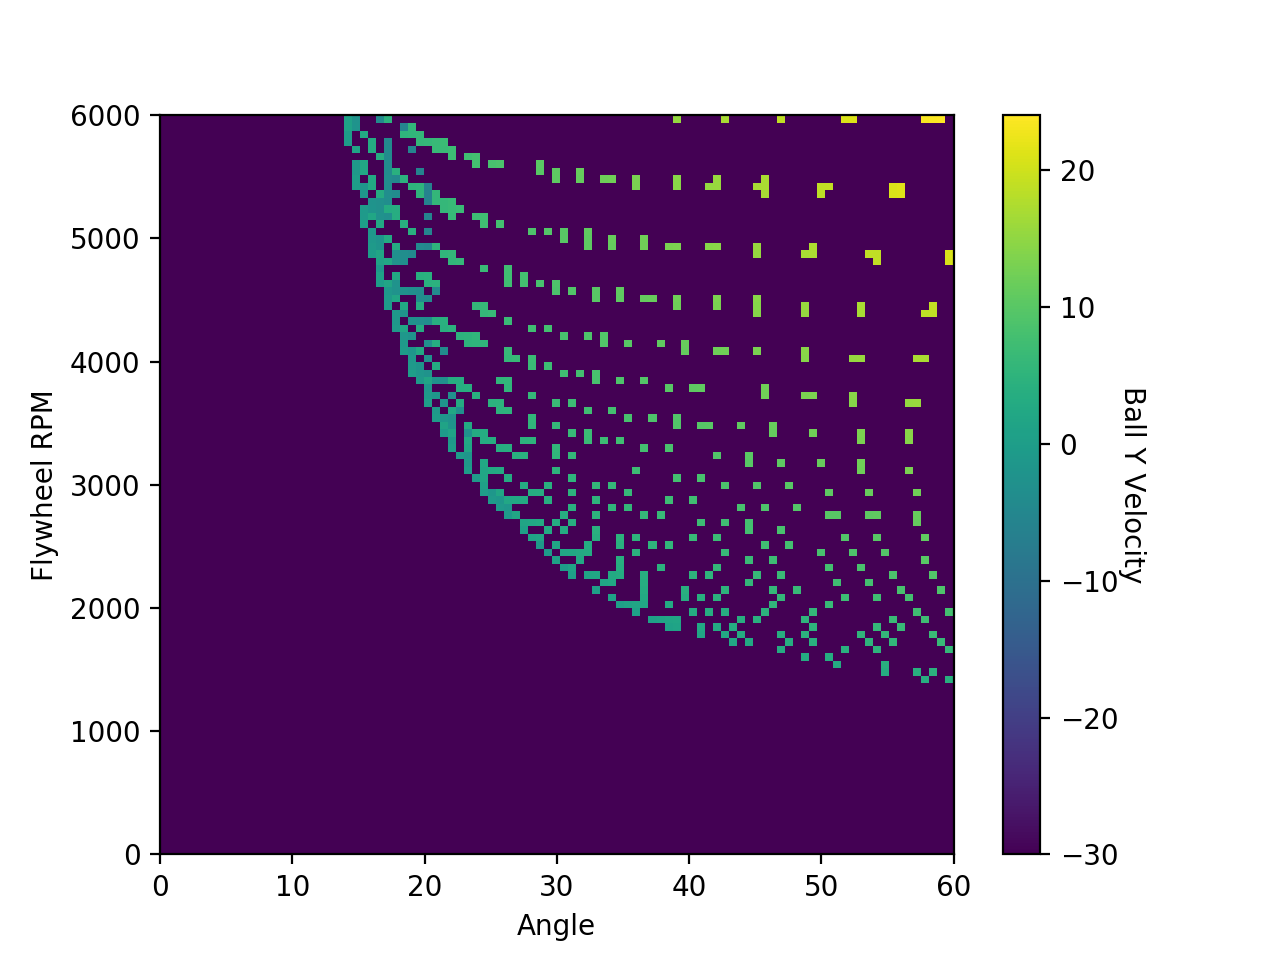

{0.6096: None, 0.9144000000000001: None, 1.2192: (60.0, 3151.5151515151515, 12.201163295405248), 1.524: (60.0, 1636.3636363636365, 4.014546676057404), 1.8288000000000002: (59.3939393939394, 1454.5454545454545, 2.1756385839175185), 2.1336: (59.3939393939394, 1393.939393939394, 1.0617275807876765), 2.4384: (58.18181818181819, 1393.939393939394, 0.4067788526131372), 2.7432000000000003: (57.57575757575758, 1393.939393939394, -0.31816181695446866), 3.048: (53.93939393939394, 1454.5454545454545, -0.12511919262741314), 3.3528000000000002: (50.909090909090914, 1515.1515151515152, -0.12444001253795756), 3.6576000000000004: (48.484848484848484, 1575.7575757575758, -0.10437757640786567), 3.9624: (46.06060606060606, 1636.3636363636365, -0.21089507302574848), 4.2672: (40.60606060606061, 1818.1818181818182, 0.4981722449300197), 4.572: (42.42424242424242, 1757.5757575757577, -0.27155302636943857), 4.8768: (38.78787878787879, 1878.787878787879, -0.021366683093286085), 5.1816: (36.36363636363637, 2000.

In [27]:
angle_res = 100
rpm_res = 100

DISTANCES = np.arange(start=2,stop=30,dtype=np.float64) * 0.3048
TARGET_HEIGHT = 2.49555
TARGET_SIZE = 0.2794

data = np.empty((angle_res, rpm_res), dtype=np.float64)
data.fill(-30)

x = np.linspace(start=0, stop=60, num=angle_res)
y = np.linspace(start=0, stop=6000, num=rpm_res)

best_initials = {}
for d in DISTANCES:
    best_initials[d] = None

for i, angle_deg in enumerate(x):
    for j, flywheel_rpm in enumerate(y):
        (positions, velocities) = run_simulation(initial_angle=radians(angle_deg), initial_velocity=flywheel_rpm/60*0.1016*pi, use_drag=True, use_magnus=True)

        for d in DISTANCES:
            best_initial = best_initials[d]
            for k in range(len(positions)):
                if abs(positions[k][0] - d) < 0.025 and abs(positions[k][1] - TARGET_HEIGHT) < 0.025:
                    data[i][j] = velocities[k][1]
                    if best_initial is None:
                        best_initial = (angle_deg, flywheel_rpm, velocities[k][1])
                    elif abs(velocities[k][1]) < abs(best_initial[2]):
                        best_initial = (angle_deg, flywheel_rpm, velocities[k][1])
                    break
            best_initials[d] = best_initial
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.pcolormesh(x, y, data)
plt.xlabel("Angle")
plt.ylabel("Flywheel RPM")
cbar = plt.colorbar()
cbar.set_label("Ball Y Velocity", rotation=270, labelpad=10)
plt.show()

#print(f"Best -- Angle: {best_initials[0]}, Flywheel RPM: {best_initials[1]}, Y Vel: {best_initials[2]}")
print(best_initials)

In [28]:
"""(positions, velocities) = run_simulation(
    radians(best_initials[0]),
    best_initials[1]/60*0.1016*pi,
    True,
    True
)
pos_x, pos_y = zip(*positions)
vel_x, vel_y = zip(*velocities)
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.plot(pos_x, pos_y)
plt.plot([DISTANCE, DISTANCE], [TARGET_HEIGHT - TARGET_SIZE / 2, TARGET_HEIGHT + TARGET_SIZE / 2], marker="o")
plt.show()"""

'(positions, velocities) = run_simulation(\n    radians(best_initials[0]),\n    best_initials[1]/60*0.1016*pi,\n    True,\n    True\n)\npos_x, pos_y = zip(*positions)\nvel_x, vel_y = zip(*velocities)\nfig = plt.figure()\nfig.add_subplot(1, 1, 1)\nplt.plot(pos_x, pos_y)\nplt.plot([DISTANCE, DISTANCE], [TARGET_HEIGHT - TARGET_SIZE / 2, TARGET_HEIGHT + TARGET_SIZE / 2], marker="o")\nplt.show()'